In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, auc, roc_curve, confusion_matrix, plot_confusion_matrix, f1_score
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from statistics import mean
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sn

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag, ne_chunk

In [2]:
DATA_DIR = '../data/'
TOOLS_DIR = '../tools/'
FILENAME = 'AllDiscussionDataCODED_USE_THIS_14Feb2020_MH.xls'
LEMMASFILETRAIN = DATA_DIR + 'train.output'
LEMMASFILETEST = DATA_DIR + 'test.output'

data = pd.read_excel( io = DATA_DIR + FILENAME ).dropna('index', 'all').dropna('columns', 'all')
# data = data.reset_index()
with open( DATA_DIR + 'stopwords-sl.txt', mode='r', encoding='utf-8') as f:
    stopwordsSLO = f.read().split( '\n' )

In [3]:
def parseLemmas( filename ):
    lemmas = []
    with open( filename, mode = 'r', encoding ='utf-8' ) as f:
        for l in f.readlines():
            line = l.strip()
            if line.startswith( '#' ):
                if line.startswith( '# newpar id =' ):
                    lemmas.append( [ ] )
                else:
                    continue
            tmp = line.split( '\t' )
            if len( tmp ) > 1:
                lemmas[ -1 ].append( tmp[ 2 ] )
#     return pd.Series( lemmas, indexes )
    return lemmas

def writeMessages( msgs, filename ):
    with open( DATA_DIR + filename + '.input', 'w', encoding='utf-8' ) as f:
        for line in msgs:
            f.write( str( line ) + '\n' )

def prepareTokens( filename ):
    command = 'cat {0}{3}.input | python {1}tokeniser.py sl -n -c -d > {2}'.format( DATA_DIR, TOOLS_DIR + 'reldi-tokeniser-master/', DATA_DIR + filename + '.conllu', filename )
    print( 'Running command ', command )
    !$command
    
def prepareLemmas( filename ):
    command = 'cd {0} python -m stanfordnlp.models.lemmatizer --model_dir models/lemma/ --model_file ssj500k+Sloleks --eval_file {1} --output_file {2} --mode predict; cd --;'.format( '../tools/classla-stanfordnlp-master;', '../../data/' + filename + '.conllu', '../../data/' + filename + '.output' )
    !$command
    
def lemmatize( messages, filename ): # filename without endings
#     filename = 'train' if train else 'test'
    
    writeMessages( messages, filename )
    prepareTokens( filename )
    prepareLemmas( filename )
    lemmas = parseLemmas( DATA_DIR + filename + '.output' )
    return lemmas

In [4]:
class LemmaTokenizer( object ):
    def __init__( self ):
        self.wnl = WordNetLemmatizer()
        
    def __call__( self, articles ):
#         print( articles )
        return articles
#         return [ self.wnl.lemmatize( t ) for t in word_tokenize( articles ) if self.wnl.lemmatize( t ) not in stopwordsSLO ]

In [5]:
data.drop( data[ pd.isna( data[ 'Message' ] ) == True ].index, inplace = True ) # remove rows with empty message
data.drop( data[ pd.isna( data[ 'Book relevance' ] ) == True ].index, inplace = True ) # remove rows with unknown book relevance

# some additional preprocessing

In [6]:
butalci = []
with open( DATA_DIR + 'butalski.txt', mode = 'r', encoding = 'utf-8' ) as f:
    for line in f.readlines():
        butalci.append( line.strip() )
        
vevericek = []
with open( DATA_DIR + 'vevericek.txt', mode = 'r', encoding = 'utf-8' ) as f:
    for line in f.readlines():
        vevericek.append( line.strip() )
        
premrazeno = []
with open( DATA_DIR + 'premrazeno.txt', mode = 'r', encoding = 'utf-8' ) as f:
    for line in f.readlines():
        premrazeno.append( line.strip() )

lemmasButalci = parseLemmas( DATA_DIR + 'butalci.output' ) # lemmatize( butalci, 'butalci' )
print( len( lemmasButalci ) )

lemmasVevericek = parseLemmas( DATA_DIR + 'vevericek.output' ) # lemmatize( vevericek, 'vevericek' )
print( len( lemmasVevericek ) )

lemmasPremrazeno = parseLemmas( DATA_DIR + 'premrazeno.output' ) # lemmatize( premrazeno, 'premrazeno' )
print( len( lemmasPremrazeno ) )

16
52
31


In [7]:
# print( len( data[ pd.isna( data[ 'Message' ] ) == True ] ) )
# print( len( data[ pd.isna( data[ 'Book relevance' ] ) == True ] ) )
X_trainO, X_testO, y_trainO, y_testO = train_test_split( data[ 'Message' ], data[ 'Book relevance' ], random_state = 42 )
# writeMessages( X_trainO )
# prepareTokens()
# prepareLemmas()

lemmasTrain = parseLemmas( LEMMASFILETRAIN )
lemmasTest = parseLemmas( LEMMASFILETEST )
# lemmas = lemmatize( X_trainO, 'train' )
# lemmas = lemmatize( X_testO, 'test' )

In [8]:
# x_relevant = len( X_trainO[ ( data[ 'Book relevance' ] == 'Yes' ) ] )
# x_nonrelevant = len( X_trainO[ ( data[ 'Book relevance' ] == 'No' ) ] )
# testNonRelevant = len( X_testO[ ( data[ 'Book relevance' ] == 'No' ) ] )

x_relevant = len( [ x for x in y_trainO if x == 'Yes' ] )
x_nonrelevant = len( [ x for x in y_trainO if x == 'No' ] )
testNonRelevant = len( [ x for x in y_testO if x == 'No' ] )

distribution = Counter( y_trainO )
labels, values = zip( *distribution.items() )

indexes = np.arange( len( labels ) )
width = 0.3

plt.subplot( 1, 2, 1 )
plt.bar( indexes, values, width, color = 'red', alpha = 0.5 )
plt.xticks( indexes + width * 0.01, labels )


distribution = Counter( y_testO )
labels, values = zip( *distribution.items() )

indexes = np.arange( len( labels ) )
width = 0.3

plt.subplot( 1, 2, 2 )
plt.bar( indexes, values, width, color = 'blue', alpha = 0.5 )
plt.xticks( indexes + width * 0.01, labels )
# plt.title( 'Distribution of examples according to relevance' )
# plt.show()
# plt.savefig( 'distribution.pdf' )
plt.close()


print( 'Book relevant texts in training set: {0}'.format( x_relevant ) )
print( 'Book non-relevant texts in training set: {0}'.format( x_nonrelevant ) )
print( 'Baseline classifier accuracy on training set: {0}'.format( x_nonrelevant / len( X_trainO ) ) )
print( 'Baseline classifier accuracy on test set: {0}'.format( testNonRelevant / len( X_testO ) ) )

Book relevant texts in training set: 1047
Book non-relevant texts in training set: 1606
Baseline classifier accuracy on training set: 0.605352431209951
Baseline classifier accuracy on test set: 0.6192090395480226


In [9]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
import numpy as np
import random

class MeasureFeatures(BaseEstimator):

    def __init__(self):
        pass

    def get_feature_names(self):
        return np.array(['length', 'contains_question_mark', 'contains_exclamation_mark'])

    def fit(self, documents, y=None):
        return self

    def transform(self, x_dataset):
        
        X_length = list()
        X_contains_question_mark = list()
        X_contains_exclamation_mark = list()
        
        for sentence in x_dataset:
            
            X_length.append(len(sentence))
            X_contains_question_mark.append(1 if str(sentence).find("?") != -1 else 0)
            X_contains_exclamation_mark.append(1 if str(sentence).find("!") != -1 else 0)

            # takes pos tag text and counts number of noun pos tags (NN, NNS etc.)

        X = np.array([X_length, X_contains_question_mark, X_contains_exclamation_mark]).T

        if not hasattr(self, 'scalar'):
            self.scalar = StandardScaler().fit(X)
        return self.scalar.transform(X)

In [10]:
'''cv = FeatureUnion([('feat', MeasureFeatures()),
                   ('tfidf', TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words=stopwordsSLO))
                  ])'''
X_train = np.array( [ value for value in X_trainO ], dtype = str )
y_train = np.array( [ value for value in y_trainO ], dtype = str )

X_test = np.array( [ value for value in X_testO ], dtype = str )
y_test = np.array( [ value for value in y_testO ], dtype = str )

# X_train_cv = cv.fit_transform( X_train.values.astype( 'U' ) )
# X_test_cv = cv.transform( X_test.values.astype( str ) )


# cv = CountVectorizer( tokenizer = lambda x : x, preprocessor = lambda x : x, stop_words = stopwordsSLO )
cv = CountVectorizer( tokenizer = lambda x : x, preprocessor = lambda x : x, analyzer = 'word', ngram_range = ( 1, 3 ) )

X_train_cv = cv.fit_transform( lemmasTrain )
X_test_cv = cv.transform( lemmasTest )

# # cv = CountVectorizer( tokenizer = LemmaTokenizer(), analyzer = 'word', ngram_range = ( 1, 3 ), stop_words = stopwordsSLO )
# cv = CountVectorizer( analyzer = 'word', ngram_range = ( 1, 3 ) )

# X_train_cv = cv.fit_transform( X_train )
# X_test_cv = cv.transform( X_test )


# word_freq_df = pd.DataFrame( X_train_cv.toarray(), columns = cv.get_feature_names() )
# top_words_df = pd.DataFrame( word_freq_df.sum() ).sort_values( 0, ascending = False )
# print( top_words_df )

Accuracy score of Naive Bayes:  0.8406779661016949
Precision score of Naive Bayes:  0.7899408284023669
Recall score of Naive Bayes:  0.7922848664688428
F1 score of Naive Bayes: 0.7911111111111112



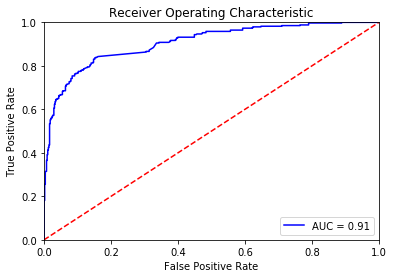

In [11]:
positiveLabel = 'Yes'

naive_bayes = MultinomialNB()
naive_bayes.fit( X_train_cv, y_train )
predictions = naive_bayes.predict( X_test_cv )

print( 'Accuracy score of Naive Bayes: ', accuracy_score( y_test, predictions ) )
print( 'Precision score of Naive Bayes: ', precision_score( y_test, predictions, pos_label = positiveLabel ) )
print( 'Recall score of Naive Bayes: ', recall_score( y_test, predictions, pos_label = positiveLabel ) )
print( 'F1 score of Naive Bayes:', f1_score( y_test, predictions, pos_label = positiveLabel ) )
print()


# cm = confusion_matrix( y_test, predictions )
# print( cm )
# df_cm = pd.DataFrame( cm, range( 2 ), range( 2 ) )
# plt.figure(figsize=(10,7))
# sn.set(font_scale=1.4) # for label size
# sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
# plt.imshow( cm )
# plt.show()


# probs = naive_bayes.predict_proba( X_test_cv )
probs = naive_bayes.predict_proba( X_test_cv )
preds = probs[ :, 1 ]
fpr, tpr, threshold = roc_curve( y_test, preds, pos_label = positiveLabel )
roc_auc = auc( fpr, tpr )

plt.title( 'Receiver Operating Characteristic' )
plt.plot( fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc )
plt.legend( loc = 'lower right') 
plt.plot( [ 0, 1 ], [ 0, 1 ], 'r--' )
plt.xlim( [ 0, 1 ] )
plt.ylim( [ 0, 1 ] )
plt.ylabel( 'True Positive Rate' )
plt.xlabel( 'False Positive Rate' )
plt.show()

Accuracy score of Logistic Regression:  0.8463276836158192
Precision score of Logistic Regression:  0.8708487084870848
Recall score of Logistic Regression:  0.7002967359050445
F1 score of Logistic Regression: 0.7763157894736843


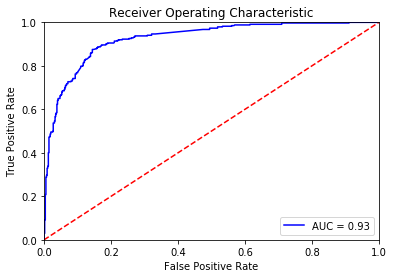

In [12]:
lrRelevant = LogisticRegression()
lrRelevant.fit( X_train_cv, y_train )
predictions = lrRelevant.predict( X_test_cv )

print( 'Accuracy score of Logistic Regression: ', accuracy_score( y_test, predictions ) )
print( 'Precision score of Logistic Regression: ', precision_score( y_test, predictions, pos_label = positiveLabel ) )
print( 'Recall score of Logistic Regression: ', recall_score( y_test, predictions, pos_label = positiveLabel ) )
print( 'F1 score of Logistic Regression:', f1_score( y_test, predictions, pos_label = positiveLabel ) )

probs = lrRelevant.predict_proba( X_test_cv )
preds = probs[ :, 1 ]
fpr, tpr, threshold = roc_curve( y_test, preds, pos_label = positiveLabel )
roc_auc = auc( fpr, tpr )

plt.title( 'Receiver Operating Characteristic' )
plt.plot( fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc )
plt.legend( loc = 'lower right') 
plt.plot( [ 0, 1 ], [ 0, 1 ], 'r--' )
plt.xlim( [ 0, 1 ] )
plt.ylim( [ 0, 1 ] )
plt.ylabel( 'True Positive Rate' )
plt.xlabel( 'False Positive Rate' )
plt.show()

Accuracy score of SVM:  0.8553672316384181
Precision score of SVM:  0.8692579505300353
Recall score of SVM:  0.7299703264094956
F1 score of SVM: 0.7935483870967741


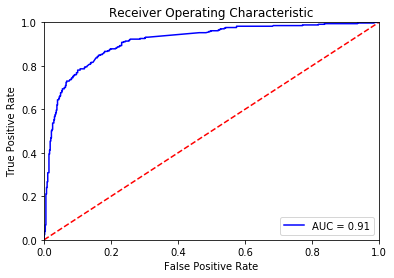

In [13]:
svm = SVC( kernel = 'linear', C = 1, probability = True )
svm.fit( X_train_cv, y_train )
predictions = svm.predict( X_test_cv )

print( 'Accuracy score of SVM: ', accuracy_score( y_test, predictions ) )
print( 'Precision score of SVM: ', precision_score( y_test, predictions, pos_label = positiveLabel ) )
print( 'Recall score of SVM: ', recall_score( y_test, predictions, pos_label = positiveLabel ) )
print( 'F1 score of SVM:', f1_score( y_test, predictions, pos_label = positiveLabel ) )

probs = svm.predict_proba( X_test_cv )
preds = probs[ :, 1 ]
fpr, tpr, threshold = roc_curve( y_test, preds, pos_label = positiveLabel )
roc_auc = auc( fpr, tpr )

plt.title( 'Receiver Operating Characteristic' )
plt.plot( fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc )
plt.legend( loc = 'lower right') 
plt.plot( [ 0, 1 ], [ 0, 1 ], 'r--' )
plt.xlim( [ 0, 1 ] )
plt.ylim( [ 0, 1 ] )
plt.ylabel( 'True Positive Rate' )
plt.xlabel( 'False Positive Rate' )
# plt.show()
plt.savefig( 'rocsvm.pdf' )

In [14]:
y_train = [ data[ 'CategoryBroad'][ i ] for i in X_trainO.index ]
y_test = [ data[ 'CategoryBroad'][ i ] for i in X_testO.index ]

labels = set( [ value for value in data[ 'CategoryBroad'] ] )
for label in labels:
    print( 'Number of examples in category {0}: {1}'.format( label, len( X_trainO[ ( data[ 'CategoryBroad' ] == label ) ] ) ) )

Number of examples in category O: 206
Number of examples in category I: 312
Number of examples in category D: 899
Number of examples in category M: 143
Number of examples in category C: 1062
Number of examples in category S: 31


In [15]:
naive_bayes = MultinomialNB()
naive_bayes.fit( X_train_cv, y_train )
predictions = naive_bayes.predict( X_test_cv )
print( 'Accuracy score of Naive Bayes: ', accuracy_score( y_test, predictions ) )
print( 'F1 score of Naive Bayes:', f1_score( y_test, predictions, average = 'weighted' ) )
print()

lr = LogisticRegression()
lr.fit( X_train_cv, y_train )
predictions = lr.predict( X_test_cv )
print( 'Accuracy score of Logistic Regression: ', accuracy_score( y_test, predictions ) )
print( 'F1 score of Logistic Regression:', f1_score( y_test, predictions, average = 'weighted' ) )
print()

svm = SVC( kernel = 'linear', C = 1, probability = True )
svm.fit( X_train_cv, y_train )
predictions = svm.predict( X_test_cv )
print( 'Accuracy score of SVM: ', accuracy_score( y_test, predictions ) )
print( 'F1 score of SVM:', f1_score( y_test, predictions, average = 'weighted' ) )
print()

Accuracy score of Naive Bayes:  0.7005649717514124
F1 score of Naive Bayes: 0.6775071832247622

Accuracy score of Logistic Regression:  0.7333333333333333
F1 score of Logistic Regression: 0.7192690511119045

Accuracy score of SVM:  0.7333333333333333
F1 score of SVM: 0.7256355379772614



In [16]:
lemmasIMap = parseLemmas( DATA_DIR + 'IMap.output' ) #lemmatize( data[ 'Message' ], 'IMap' )
index = int( len( lemmasIMap ) * 0.7 )
X_train, y_train = lemmasIMap[ 0 : index ], data[ 'Book relevance' ][ 0 : index ]
X_test, y_test = lemmasIMap[ index : ], data[ 'Book relevance' ][ index : ]

# print( len( [ x for x in y_test if x == 'Yes' ] ) )
# print( len( [ x for x in y_test if x == 'No' ] ) )
# print()
# print( len( [ x for x in y_train if x == 'Yes' ] ) )
# print( len( [ x for x in y_train if x == 'No' ] ) )


cv = CountVectorizer( tokenizer = lambda x : x, preprocessor = lambda x : x, analyzer = 'word', ngram_range = ( 1, 3 ) )

X_train_cv = cv.fit_transform( X_train )
X_test_cv = cv.transform( X_test )

# modelRelevant = LogisticRegression()
modelRelevant = SVC( kernel = 'linear', C = 1, probability = True )
modelRelevant.fit( X_train_cv, data[ 'Book relevance' ][ 0 : index ] )

# Cross validation
clf = Pipeline( [ ( 'vect', cv ), ( 'svm', modelRelevant ) ] )
scores = cross_validate( clf, X_train, data[ 'Book relevance' ][ 0 : index ], cv = 5, scoring = [ 'accuracy', 'f1_weighted' ] )
# print( 'Accuracy scores for Relevant model', scores[ 'test_accuracy' ] )
# print( 'F1 scores for Relevant model', scores[ 'test_f1_weighted' ] )
print( 'Average accuracy for relevant model', mean( scores[ 'test_accuracy' ] ) )
print( 'Average F1 score for relevant model', mean( scores[ 'test_f1_weighted' ] ) )
print()

modelCategory = LogisticRegression()
# modelCategory = SVC( kernel = 'linear', C = 1, probability = True )
modelCategory.fit( X_train_cv, data[ 'CategoryBroad' ][ 0 : index ] )

# Cross validation
clf = Pipeline( [ ( 'vect', cv ), ( 'svm', modelCategory ) ] )
scores = cross_validate( clf, X_train, data[ 'CategoryBroad' ][ 0 : index ], cv = 5, scoring = [ 'accuracy', 'f1_weighted' ] )
# print( 'Accuracy scores for Category model', scores[ 'test_accuracy' ] )
# print( 'F1 scores for Category model', scores[ 'test_f1_weighted' ] )
print( 'Average accuracy for Category model', mean( scores[ 'test_accuracy' ] ) )
print( 'Average F1 score for Category model', mean( scores[ 'test_f1_weighted' ] ) )
print()

batchSize = 10
relevance = []
softRelevance = [ 'D', 'S', 'M' ]
for i in range( 0, len( X_test ), batchSize ):
    batch = X_test[ i : i + batchSize ]
    batch_cv = cv.transform( batch )
    predictionsRelevant = modelRelevant.predict( batch_cv )
    batchYes = 0
    batchNo = 0
    for j in range( 0, len( predictionsRelevant ) ):
        if predictionsRelevant[ j ] == 'Yes':
#             relevance.append( 'Yes' )
                batchYes += 1
        else:
            category = modelCategory.predict( batch_cv[ j ] )
#             relevance.append( 'Yes' if category == 'D' or category == 'S' or category == 'M' else 'No' )
            if category in softRelevance:
                batchYes += 1
            else:
                batchNo += 1
    relevance.append( 'Yes' if batchYes >= batchNo else 'No' )
for i in range( 0, len( relevance ), 5 ):
    batch = relevance[ i : i + 5 ]
    if all( [ x == 'No' for x in batch ] ):
        print( 'The teacher must intervene' )

Average accuracy for relevant model 0.8263269794721407
Average F1 score for relevant model 0.8185878053036321

Average accuracy for Category model 0.6522523623330075
Average F1 score for Category model 0.6172205589787284

The teacher must intervene
The teacher must intervene
The teacher must intervene
